<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1999 non-null   object 
 1   price          1999 non-null   int64  
 2   level          1999 non-null   int64  
 3   levels         1999 non-null   int64  
 4   rooms          1999 non-null   int64  
 5   area           1999 non-null   float64
 6   kitchen_area   1999 non-null   float64
 7   geo_lat        1999 non-null   float64
 8   geo_lon        1999 non-null   float64
 9   building_type  1999 non-null   object 
 10  object_type    1999 non-null   object 
 11  postal_code    1999 non-null   object 
 12  street_id      1999 non-null   object 
 13  id_region      1999 non-null   object 
 14  house_id       1999 non-null   object 
dtypes: float64(4), int64(4), object(7)
memory usage: 234.4+ KB
До обработки:
 None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entrie

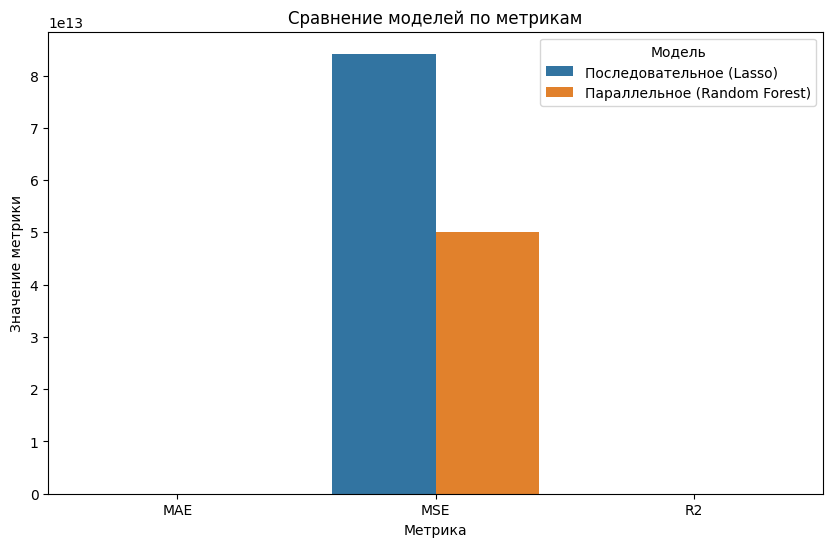

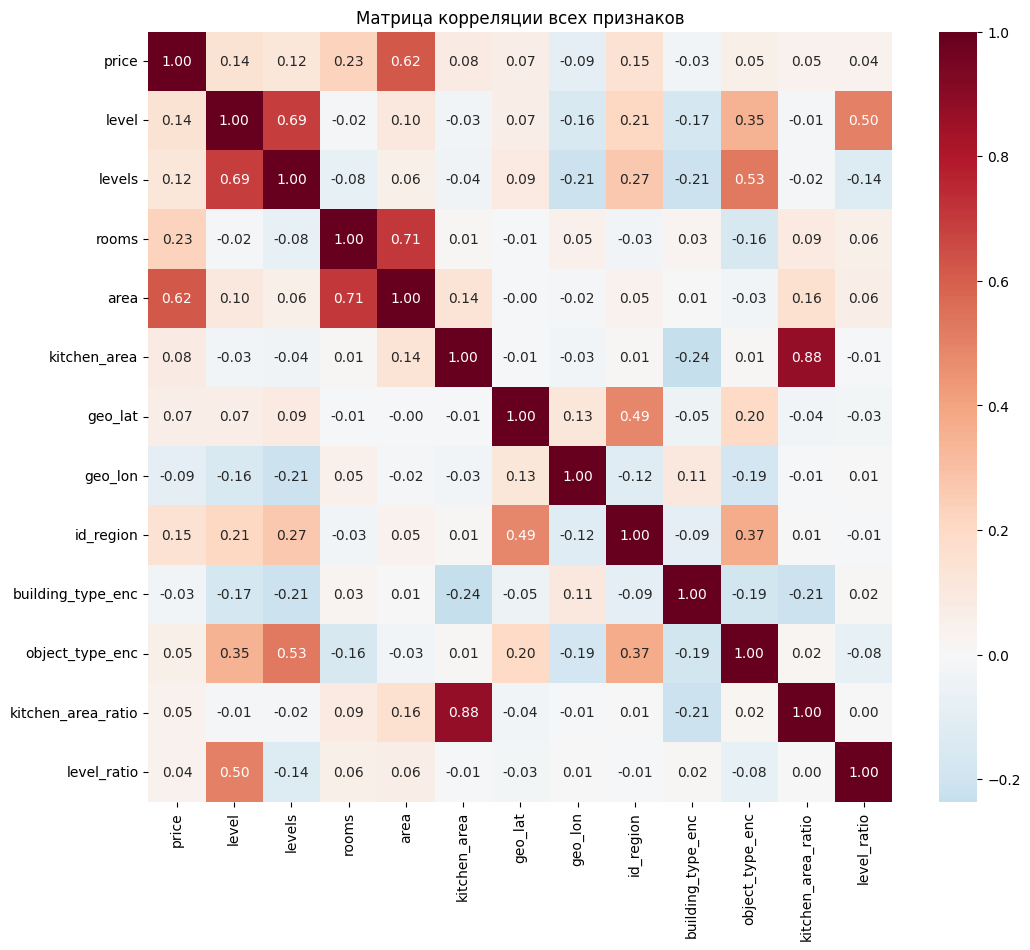

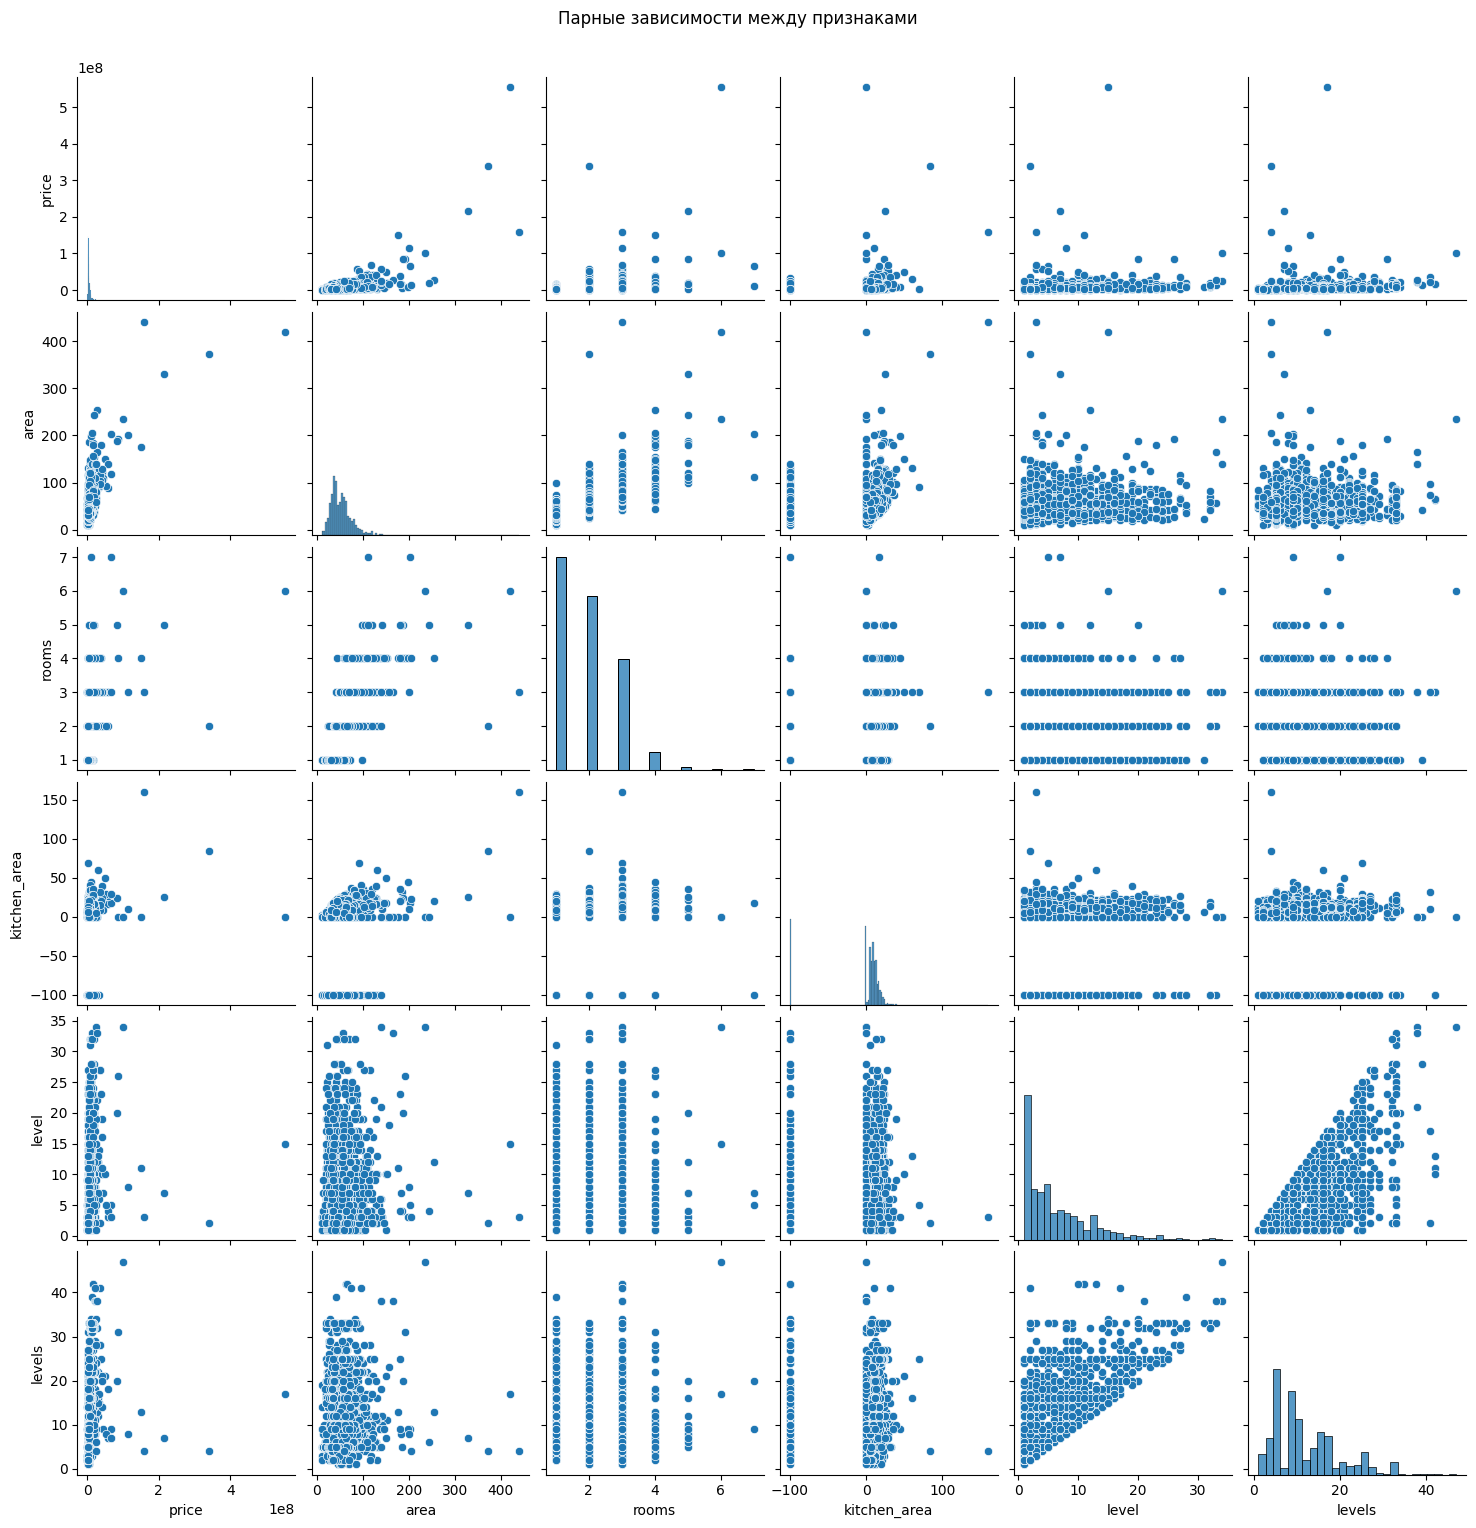

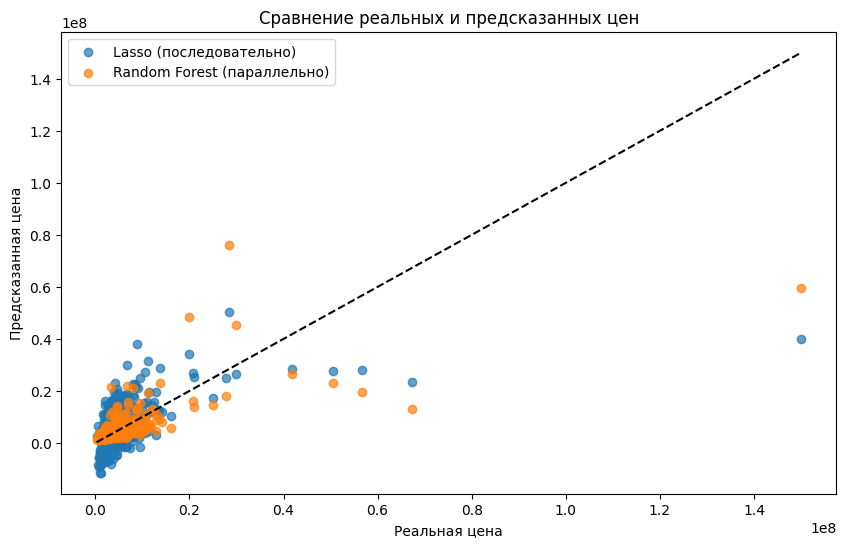

In [16]:
# --- Усовершенствованный пайплайн: Улучшение качества модели ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import time

# Загружаем датасет
file_path = 'input_data_1.csv'  # Замените путь на свой
raw_df = pd.read_csv(file_path)

# Разделение по разделителю ;
df = raw_df.iloc[:, 0].str.split(';', expand=True)
df.columns = [
    'date', 'price', 'level', 'levels', 'rooms', 'area', 'kitchen_area',
    'geo_lat', 'geo_lon', 'building_type', 'object_type', 'postal_code',
    'street_id', 'id_region', 'house_id'
]

# Приведение типов
numeric_cols = ['price', 'level', 'levels', 'rooms', 'area', 'kitchen_area', 'geo_lat', 'geo_lon']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Базовая обработка
print("До обработки:\n", df.info())

# --- Улучшения по твоему описанию ---

# 1. Корректная обработка студий
# rooms == -1 (студия) заменяем на 1
df['rooms'] = df['rooms'].replace(-1, 1)

# 2. Категориальные признаки
le_building = LabelEncoder()
df['building_type_enc'] = le_building.fit_transform(df['building_type'])

le_object = LabelEncoder()
df['object_type_enc'] = le_object.fit_transform(df['object_type'])

# 3. Удаление ненужных признаков
columns_to_drop = ['postal_code', 'street_id', 'house_id', 'building_type', 'object_type', 'date']
df = df.drop(columns=columns_to_drop)

# 4. Создание новых признаков
# Отношение кухни к общей площади
df['kitchen_area_ratio'] = df['kitchen_area'] / df['area']

# Отношение этажа к количеству этажей дома
df['level_ratio'] = df['level'] / df['levels']

# Удаление пропусков, которые могли появиться при создании новых признаков
df = df.dropna()

print("После обработки:\n", df.info())

# --- Подготовка данных ---

X = df.drop('price', axis=1)
y = df['price']

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)
print(f"Доля объяснённой дисперсии после PCA: {np.sum(pca.explained_variance_ratio_):.2f}")

# Деление на train/test
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# --- Обучение моделей ---

# Последовательное обучение (Lasso)
print("\nПоследовательное обучение модели (Lasso)")
start_time = time.time()
lasso = Lasso(alpha=0.1, max_iter=10000)
lasso.fit(X_train, y_train)
y_pred_seq = lasso.predict(X_test)
end_time = time.time()

mae_seq = mean_absolute_error(y_test, y_pred_seq)
mse_seq = mean_squared_error(y_test, y_pred_seq)
r2_seq = r2_score(y_test, y_pred_seq)
print(f"MAE: {mae_seq:.2f}")
print(f"MSE: {mse_seq:.2f}")
print(f"R2: {r2_seq:.2f}")
print(f"Время обучения: {end_time - start_time:.2f} секунд")

# Параллельное обучение (Random Forest)
print("\nПараллельное обучение модели (Random Forest)")
start_time = time.time()
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
y_pred_par = rf.predict(X_test)
end_time = time.time()

mae_par = mean_absolute_error(y_test, y_pred_par)
mse_par = mean_squared_error(y_test, y_pred_par)
r2_par = r2_score(y_test, y_pred_par)
print(f"MAE: {mae_par:.2f}")
print(f"MSE: {mse_par:.2f}")
print(f"R2: {r2_par:.2f}")
print(f"Время обучения: {end_time - start_time:.2f} секунд")

# --- Сравнение моделей ---

results = pd.DataFrame({
    'Метрика': ['MAE', 'MSE', 'R2'],
    'Последовательное (Lasso)': [mae_seq, mse_seq, r2_seq],
    'Параллельное (Random Forest)': [mae_par, mse_par, r2_par]
})

print("\nСравнительная таблица моделей:")
print(results)

# --- Визуализация сравнения ---

results_melted = results.melt(id_vars='Метрика', var_name='Модель', value_name='Значение')
plt.figure(figsize=(10, 6))
sns.barplot(x='Метрика', y='Значение', hue='Модель', data=results_melted)
plt.title('Сравнение моделей по метрикам')
plt.ylabel('Значение метрики')
plt.show()

# --- Дополнительная визуализация: Матрица корреляции ---

plt.figure(figsize=(12, 10))
corr_matrix = df.corr()

sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
plt.title('Матрица корреляции всех признаков')
plt.show()

# --- Дополнительная визуализация: Парные графики (Pairplot) ---

selected_features = ['price', 'area', 'rooms', 'kitchen_area', 'level', 'levels']
sns.pairplot(df[selected_features])
plt.suptitle('Парные зависимости между признаками', y=1.02)
plt.show()

# --- Визуализация предсказаний ---

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_seq, label='Lasso (последовательно)', alpha=0.7)
plt.scatter(y_test, y_pred_par, label='Random Forest (параллельно)', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Реальная цена')
plt.ylabel('Предсказанная цена')
plt.title('Сравнение реальных и предсказанных цен')
plt.legend()
plt.show()

Проведённая работа
В ходе анализа были предприняты следующие шаги:

- Загрузка и предобработка данных:
- Данные были распарсены, приведены к правильным типам
- Исправлены аномалии
- Закодированы категориальные признаки (building_type, object_type)
- Исключены бессмысленные признаки (postal_code, street_id, house_id)
- Созданы новые признаки (kitchen_area_ratio, level_ratio) для усиления информативности данных

Разведочный анализ данных (EDA):

- Построены графики распределения цен, зависимости между признаками
- Построена матрица корреляции между признаками

Уменьшение размерности (PCA):

- Для ускорения обучения и устранения мультиколлинеарности признаков

Построение моделей:

- Последовательная модель: линейная регрессия с L1-регуляризацией (Lasso)
- Параллельная модель: Random Forest с использованием всех ядер процессора

Оценка моделей:

- Использовались метрики MAE, MSE, R²
- Сравнение производительности и качества моделей
- Построены матрица корреляции, графики важности признаков, парные зависимости

Ключевое наблюдение:

- Random Forest показал лучшие результаты по всем метрикам благодаря способности учитывать сложные нелинейные зависимости между признаками

Анализ проблем и ограничений

Несмотря на принятые меры по улучшению модели, качество предсказаний осталось невысоким( Это объясняется:

- Недостаточно информативных признаков о самих объектах недвижимости
- Нет данных о состоянии квартиры, году постройки дома, расположении относительно центра, инфраструктуре
- В датасете были как дешёвые квартиры, так и очень дорогие, что затрудняет обучение модели
- Корреляция большинства признаков с ценой была низкой

Вывод:

- В текущем состоянии модели способны давать грубую оценку стоимости недвижимости
- Для достижения промышленного уровня качества необходимо существенно доработать исходные данные 

Что можно улучшить (но здесь нужен очень тчательный подход и большие знания):

- Расширить набор признаков: добавить год постройки, тип отделки, наличие ремонта, транспортную доступность, социальную инфраструктуру
- Провести кластеризацию объектов: например, по районам или типу недвижимости